### This project analyze the standard VPC Flow Logs from AWS, to detect potential threat from the data file.
### The website to analyze is Softrams, LLC user log in page.
### The goal of this project is to use machine learning to detect in which timestamp there exist abnormally high traffic. 

In [1]:
import pandas as pd
import os
import json
import datetime
import matplotlib.pyplot as plt
import csv
import numpy as np
%matplotlib inline

#### First we append all the csv files into the dataset

In [2]:
data = []
fileNum = 2
while fileNum < 115: 
    with open('data/logs-insights-results-' + str(fileNum) + '.csv') as f:
        for line in csv.DictReader(f, fieldnames=('timestamp', 'message')):
            data.append(line)
        fileNum += 1

In [3]:
# check keys
data[0]

{'timestamp': '@timestamp', 'message': '@message'}

In [4]:
# check size
len(data)

822226

## This decodes to message into different attributes:
#### account: the account of the user 
#### sourceIP: the ip address of the sender of the message
#### destIP: the receiver of the message
#### interface: the log stream of the message
#### srcPort: internet port of sender
#### dstPort: internet port of receiver
#### protocol: the network protocol used to communicate the message
#### byte: the size of the message
#### packets: number of segments of the message
#### startTime: the integer start time in unix time form
#### timeTook: exact time it took to send the message
#### status: either "ACCEPT" or "REJECT". Accept will be 1 and reject will be represented as 0.

In [5]:
date = []
time = []
account = []
sourceIP = []
destIP = []
interface = []
srcPort = []
dstPort = []
protocol = []
byte = []
packets = []
startTime = []
timeTook = []
status = []

na = None
i = 1

while i < len(data):
    msg = data[i].get('message',na)
    # for messages with no data will get filtered out here
    if 'ACCEPT' in msg or 'REJECT' in msg:
        timeTokens = data[i].get('timestamp',na).split()
        date.append(timeTokens[0])
        time.append(timeTokens[1])
        tokens = msg.split()
        account.append(tokens[1])
        interface.append(tokens[2])
        sourceIP.append(tokens[3])
        destIP.append(tokens[4])
        #storing actions
        temp = 5
        tempStr = ''
        while(tokens[temp+1] != "OK"):
            tempStr = tempStr + tokens[temp] + ' '
            temp += 1
        actionTokens = tempStr.split()
        srcPort.append(actionTokens[0])
        dstPort.append(actionTokens[1])
        protocol.append(actionTokens[2])
        packets.append(actionTokens[3])
        byte.append(actionTokens[4])
        startTime.append(int(actionTokens[5]))
        timeTook.append(int(actionTokens[6]) - int(actionTokens[5]))
        if(tokens[temp] == 'ACCEPT'):
            status.append(1)
        else:
            status.append(0)
    i += 1
# print label as well
print('Date: ' + date[0])
print('Time: ' + time[0])
print('AWS account: ' + account[0])
print('Network interface: ' + interface[0])
print('Source IP: ' + sourceIP[0])
print('Destination IP: ' + destIP[0])
print('Status: ' + str(status[0]))
print('Source port: ' + srcPort[0])
print('Destination port: ' + dstPort[0])
print('Protocol: ' + protocol[0])
print('Packets of data: ' + packets[0])
print('Size of data: ' + byte[0] + ' bytes')
print('Start time: ' + str(startTime[0]))
print('Time used: ' + str(timeTook[0]) + ' seconds')
print('New size of dataset after filtering: ' + str(len(date)))

Date: 2021-02-10
Time: 18:15:00.000
AWS account: 430405884063
Network interface: eni-0b6ce86ea40aaa41b
Source IP: 50.245.225.205
Destination IP: 172.16.1.52
Status: 1
Source port: 9622
Destination port: 80
Protocol: 6
Packets of data: 5
Size of data: 582 bytes
Start time: 1612980900
Time used: 9 seconds
New size of dataset after filtering: 813100


In [6]:
df = pd.DataFrame({
    "date":date,
    "time":time,
    "account":account,
    "interface":interface,
    "sourceIP":sourceIP,
    "destIP":destIP,
    "srcPort":srcPort,
    "dstPort":dstPort,
    "protocol":protocol,
    "packets":packets,
    "byte":byte,
    "startTime":startTime,
    "timeTook":timeTook,
    "status":status
})

In [7]:
df.head(10)

,date,time,account,interface,sourceIP,destIP,srcPort,dstPort,protocol,packets,byte,startTime,timeTook,status
0,2021-02-10,18:15:00.000,430405884063,eni-0b6ce86ea40aaa41b,50.245.225.205,172.16.1.52,9622,80,6,5,582,1612980900,9,1
1,2021-02-10,18:15:00.000,430405884063,eni-0b6ce86ea40aaa41b,172.16.1.52,50.245.225.205,80,9622,6,5,689,1612980900,9,1
2,2021-02-10,18:15:00.000,430405884063,eni-0b6ce86ea40aaa41b,50.245.225.205,172.16.1.52,22050,80,6,6,648,1612980900,9,1
3,2021-02-10,18:15:00.000,430405884063,eni-0b6ce86ea40aaa41b,172.16.1.52,50.245.225.205,80,22050,6,5,582,1612980900,9,1
4,2021-02-10,18:15:00.000,430405884063,eni-0b6ce86ea40aaa41b,50.245.225.205,172.16.1.52,51466,80,6,8,723,1612980900,9,1
5,2021-02-10,18:15:00.000,430405884063,eni-0b6ce86ea40aaa41b,172.16.1.52,50.245.225.205,80,51466,6,11,10996,1612980900,9,1
6,2021-02-10,18:15:00.000,430405884063,eni-0b6ce86ea40aaa41b,50.245.225.205,172.16.1.52,49748,80,6,7,705,1612980900,9,1
7,2021-02-10,18:15:00.000,430405884063,eni-0b6ce86ea40aaa41b,172.16.1.52,50.245.225.205,80,49748,6,13,12958,1612980900,9,1
8,2021-02-10,18:15:00.000,430405884063,eni-0b6ce86ea40aaa41b,50.245.225.205,172.16.1.52,18681,80,6,5,572,1612980900,9,1
9,2021-02-10,18:15:00.000,430405884063,eni-0b6ce86ea40aaa41b,172.16.1.52,50.245.225.205,80,18681,6,5,638,1612980900,9,1


#### Perform some statistics for a general view of the data

In [8]:
df['timeTook'].describe()

count    813100.000000
mean         14.809075
std           9.398437
min           0.000000
25%          13.000000
50%          13.000000
75%          14.000000
max          61.000000
Name: timeTook, dtype: float64

In [9]:
df['time'].describe()

count           813100
unique            7915
top       19:35:28.000
freq              4880
Name: time, dtype: object

In [10]:
uniqueIP = set()
for i in sourceIP:
    uniqueIP.add(i)
for i in destIP:
    uniqueIP.add(i)
print("There are " + str(len(uniqueIP)) + " unique IP address.")

There are 1654 unique IP address.


#### Here are the chart of most appeared ip address from source to destination

In [11]:
df.sourceIP.value_counts()

172.16.1.52        358159
172.16.1.196       322741
73.180.143.70       26499
10.3.252.33         23185
50.245.225.205      11925
                    ...  
168.119.60.98           1
178.46.210.193          1
192.241.214.211         1
80.82.77.33             1
193.118.53.141          1
Name: sourceIP, Length: 1654, dtype: int64

<AxesSubplot:>

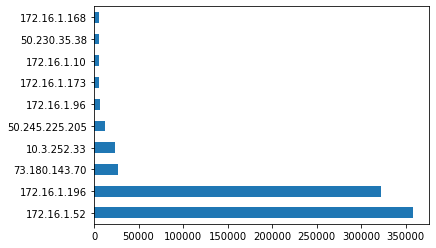

In [12]:
df.sourceIP.value_counts().head(10).plot.barh()

In [13]:
df.destIP.value_counts()

172.16.1.52       359118
172.16.1.196      334239
73.180.143.70      26493
50.245.225.205     11925
172.16.1.241        8379
                   ...  
223.166.74.29          1
52.247.201.54          1
209.17.96.74           1
138.68.161.204         1
35.187.190.226         1
Name: destIP, Length: 212, dtype: int64

<AxesSubplot:>

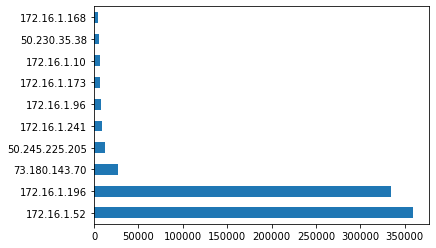

In [14]:
df.destIP.value_counts().head(10).plot.barh()

In [15]:
# 1 is accept, 0 is reject
df.status.value_counts()

1    789081
0     24019
Name: status, dtype: int64

In [16]:
df.time.value_counts()

19:35:28.000    4880
19:35:01.000    4374
19:32:00.000    4227
19:34:00.000    4146
19:33:01.000    4052
                ... 
18:38:55.000       1
21:19:32.000       1
20:25:58.000       1
20:25:05.000       1
19:45:16.000       1
Name: time, Length: 7915, dtype: int64

<AxesSubplot:>

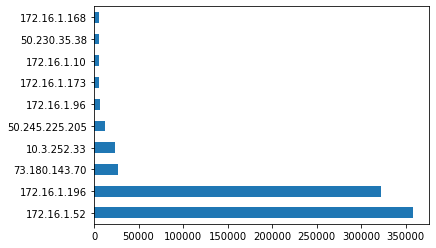

In [17]:
df.sourceIP.value_counts().head(10).plot.barh()

<AxesSubplot:>

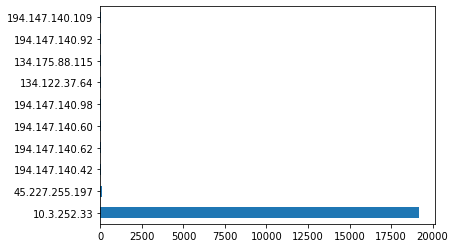

In [18]:
# check on the source ip address for the rejected 
df[df['status']==0].sourceIP.value_counts().head(10).plot.barh()

<AxesSubplot:>

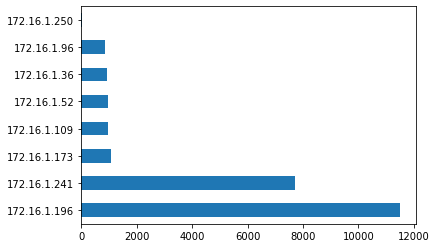

In [19]:
df[df['status']==0].destIP.value_counts().head(10).plot.barh()

<AxesSubplot:>

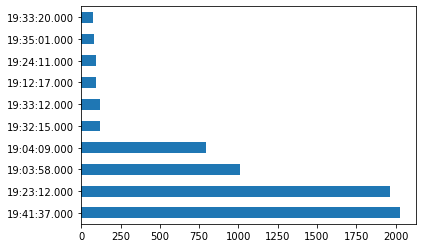

In [20]:
# what time are all the rejections come from
df[df['status']==0].time.value_counts().head(10).plot.barh()

<AxesSubplot:>

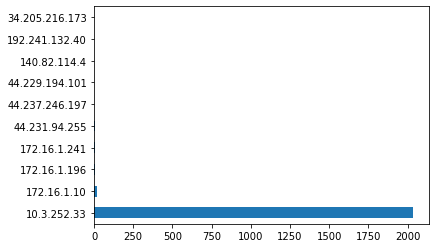

In [21]:
# why is this time has so many rejects? check for the ip address from this time
df[df['time'].str.contains("19:41:37.000")].sourceIP.value_counts().head(10).plot.barh()

<AxesSubplot:>

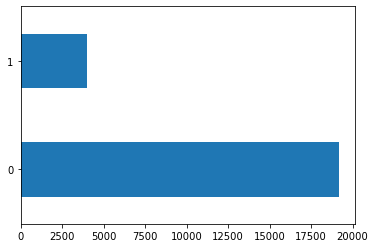

In [22]:
df[df['sourceIP'].str.contains("10.3.252.33")].status.value_counts().plot.barh()
#use lambda to calculate percentage of accept/reject

In [23]:
df['status'].describe()
#how many nodata?

count    813100.000000
mean          0.970460
std           0.169315
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           1.000000
Name: status, dtype: float64

### The IP address 10.3.252.33 is suspicious as it sends 2000+ requests in 1 second, 
### and most of the rejections come from this address
### Further investigation is needed

## Building unsupervised meachine learning model

In [24]:
df.head()

,date,time,account,interface,sourceIP,destIP,srcPort,dstPort,protocol,packets,byte,startTime,timeTook,status
0,2021-02-10,18:15:00.000,430405884063,eni-0b6ce86ea40aaa41b,50.245.225.205,172.16.1.52,9622,80,6,5,582,1612980900,9,1
1,2021-02-10,18:15:00.000,430405884063,eni-0b6ce86ea40aaa41b,172.16.1.52,50.245.225.205,80,9622,6,5,689,1612980900,9,1
2,2021-02-10,18:15:00.000,430405884063,eni-0b6ce86ea40aaa41b,50.245.225.205,172.16.1.52,22050,80,6,6,648,1612980900,9,1
3,2021-02-10,18:15:00.000,430405884063,eni-0b6ce86ea40aaa41b,172.16.1.52,50.245.225.205,80,22050,6,5,582,1612980900,9,1
4,2021-02-10,18:15:00.000,430405884063,eni-0b6ce86ea40aaa41b,50.245.225.205,172.16.1.52,51466,80,6,8,723,1612980900,9,1


In [25]:
df.columns

Index(['date', 'time', 'account', 'interface', 'sourceIP', 'destIP', 'srcPort',
       'dstPort', 'protocol', 'packets', 'byte', 'startTime', 'timeTook',
       'status'],
      dtype='object')

#### The features we are interested are related to the potential threat to the server, which is the large amount of requests in a small portion of time.
#### Therefore, startTime and timeTook are the features we are interested.

In [26]:
selected_features = ['startTime','timeTook']
X = df[selected_features].values
y = df['time'].values

In [27]:
print(X[0])

[1612980900          9]


In [28]:
X.shape

(813100, 2)

#### Using k-means algorithm from timeTook over startTime to group all the data into clusters to better identify the potential threat.

In [29]:
import numpy as np
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
import warnings
import matplotlib.cbook
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [30]:
print(X)

[[1612980900          9]
 [1612980900          9]
 [1612980900          9]
 ...
 [1613001598          8]
 [1613001598          8]
 [1613001596          1]]


In [31]:
print(y)

['18:15:00.000' '18:15:00.000' '18:15:00.000' ... '23:59:58.000'
 '23:59:58.000' '23:59:56.000']


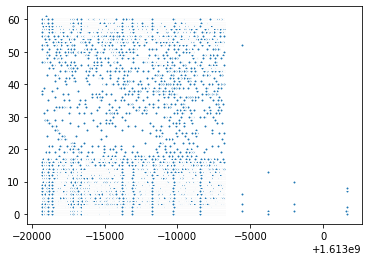

In [32]:
# Scatter plot the data to check
plt.scatter(X[:, 0], X[:, 1], marker='.', edgecolors='white')
plt.show()

[3 3 3 ... 1 1 1]
[[1.61298572e+09 1.48703637e+01]
 [1.61299066e+09 3.04568177e+01]
 [1.61298355e+09 1.36707109e+01]
 [1.61298115e+09 1.74305049e+01]
 [1.61298459e+09 1.35698954e+01]]


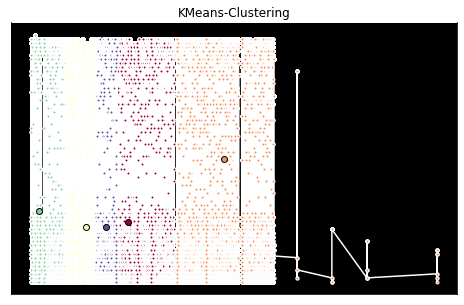

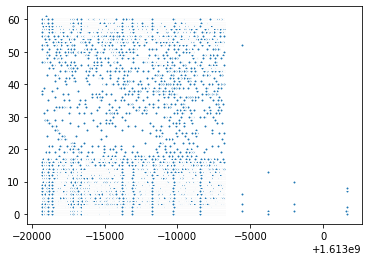

In [33]:
""" 
Set K-Means Clustering, 
n_clusters is number of clusters to form, 
k-means++ for smart way to converge faster
n_init initializes different centroids each run and best output is shown in terms of inertia
"""
n = 5
k_means = KMeans(init="k-means++", n_clusters=n, n_init=15)

# Fit KMeans model with feature matrix, X
k_means.fit(X)

# Grab the labels for each point in the model
k_means_labels = k_means.labels_
print(k_means_labels)

# Get the coordinates of the cluster centers
k_means_cluster_centers = k_means.cluster_centers_
print(k_means_cluster_centers)

# Visualize the Plot
# Initialize plot with the specified dimensions.
fig = plt.figure(figsize=(8, 5))

# Colors uses a color map, which will produce an array of colors based on the number of labels there are.
colors = plt.get_cmap('Spectral')(np.linspace(0, 1, len(set(k_means_labels))))

# Create a plot with a black background for better visibility
ax = fig.add_subplot(1, 1, 1, facecolor='black')

# For loop that plots the data points and centroids.
# k will range from 0-3, which will match the possible clusters that each data point is in.
for k, col in zip(range(n), colors):
    # Create a list of all data points, where the data points that are in the cluster are labeled as true
    # Else they are labeled as false.
    members = (k_means_labels == k)

    # Define the centroid, or cluster center.
    cluster_center = k_means_cluster_centers[k]

    # Plots the data points with color col.
    ax.plot(X[members, 0],
            X[members, 1],
            'w',
            markerfacecolor=col,
            marker='.')

    # Plots the centroids with specified color, but with a darker outline
    ax.plot(cluster_center[0],
            cluster_center[1],
            'o',
            markerfacecolor=col,
            markeredgecolor='k',
            markersize=6)

# Title of the plot
ax.set_title('KMeans-Clustering')

# Remove x-axis ticks
ax.set_xticks(())

# Remove y-axis ticks
ax.set_yticks(())

# Show the plot
plt.show()

# Display the scatter plot from above for comparison.
plt.scatter(X[:, 0], X[:, 1], marker='.', edgecolors='white')


#### Cluster 2, 3, and 4 are too packed together

#### Now, each log has a label from the cluster they belong, we can group each logs by their labels

In [34]:
df['cluster_label'] = k_means_labels

In [35]:
df.head(10)

,date,time,account,interface,sourceIP,destIP,srcPort,dstPort,protocol,packets,byte,startTime,timeTook,status,cluster_label
0,2021-02-10,18:15:00.000,430405884063,eni-0b6ce86ea40aaa41b,50.245.225.205,172.16.1.52,9622,80,6,5,582,1612980900,9,1,3
1,2021-02-10,18:15:00.000,430405884063,eni-0b6ce86ea40aaa41b,172.16.1.52,50.245.225.205,80,9622,6,5,689,1612980900,9,1,3
2,2021-02-10,18:15:00.000,430405884063,eni-0b6ce86ea40aaa41b,50.245.225.205,172.16.1.52,22050,80,6,6,648,1612980900,9,1,3
3,2021-02-10,18:15:00.000,430405884063,eni-0b6ce86ea40aaa41b,172.16.1.52,50.245.225.205,80,22050,6,5,582,1612980900,9,1,3
4,2021-02-10,18:15:00.000,430405884063,eni-0b6ce86ea40aaa41b,50.245.225.205,172.16.1.52,51466,80,6,8,723,1612980900,9,1,3
5,2021-02-10,18:15:00.000,430405884063,eni-0b6ce86ea40aaa41b,172.16.1.52,50.245.225.205,80,51466,6,11,10996,1612980900,9,1,3
6,2021-02-10,18:15:00.000,430405884063,eni-0b6ce86ea40aaa41b,50.245.225.205,172.16.1.52,49748,80,6,7,705,1612980900,9,1,3
7,2021-02-10,18:15:00.000,430405884063,eni-0b6ce86ea40aaa41b,172.16.1.52,50.245.225.205,80,49748,6,13,12958,1612980900,9,1,3
8,2021-02-10,18:15:00.000,430405884063,eni-0b6ce86ea40aaa41b,50.245.225.205,172.16.1.52,18681,80,6,5,572,1612980900,9,1,3
9,2021-02-10,18:15:00.000,430405884063,eni-0b6ce86ea40aaa41b,172.16.1.52,50.245.225.205,80,18681,6,5,638,1612980900,9,1,3


In [36]:
uniqueClusters = set()
for i in k_means_labels:
    uniqueClusters.add(i)
print("There are " + str(len(uniqueClusters)) + " unique clusters.")

There are 5 unique clusters.


In [37]:
cluster1 = []
cluster2 = []
cluster3 = []
cluster4 = []
cluster5 = []
for index, line in df.iterrows():
    if line['cluster_label'] == 0:
        cluster1.append(line)
    elif line['cluster_label'] == 1:
        cluster2.append(line)
    elif line['cluster_label'] == 2:
        cluster3.append(line)
    elif line['cluster_label'] == 3:
        cluster4.append(line)
    elif line['cluster_label'] == 4:
        cluster5.append(line)
print('Size of cluster 1: ' + str(len(cluster1)))
print('Size of cluster 2: ' + str(len(cluster2)))
print('Size of cluster 3: ' + str(len(cluster3)))
print('Size of cluster 4: ' + str(len(cluster4)))
print('Size of cluster 5: ' + str(len(cluster5)))

Size of cluster 1: 306226
Size of cluster 2: 26446
Size of cluster 3: 176958
Size of cluster 4: 37537
Size of cluster 5: 265933


In [38]:
print('Total size of all clusters: ' + str(len(cluster1) + len(cluster2) + len(cluster3) + len(cluster4) + len(cluster5)))
print('Size of dataset: ' + str(len(df)))
print('The sizes matches, each data is put into a dataset')

Total size of all clusters: 813100
Size of dataset: 813100
The sizes matches, each data is put into a dataset


#### Analyze the ip address in clusters

<AxesSubplot:>

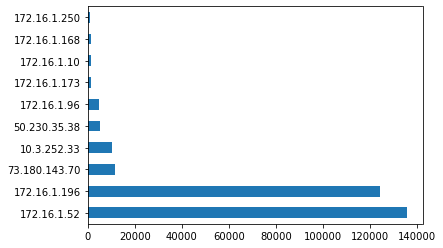

In [39]:
df[df['cluster_label']==0].sourceIP.value_counts().head(10).plot.barh()

<AxesSubplot:>

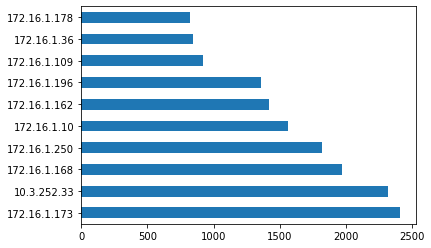

In [40]:
df[df['cluster_label']==1].sourceIP.value_counts().head(10).plot.barh()

<AxesSubplot:>

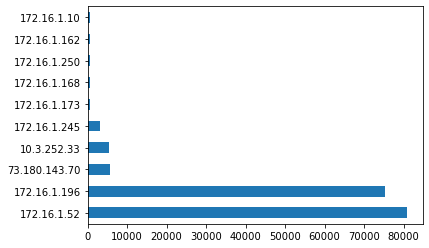

In [41]:
df[df['cluster_label']==2].sourceIP.value_counts().head(10).plot.barh()

<AxesSubplot:>

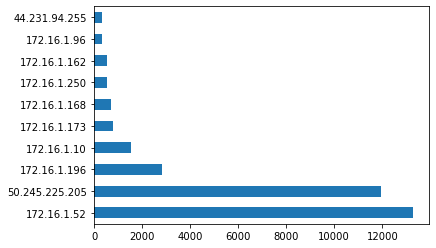

In [42]:
df[df['cluster_label']==3].sourceIP.value_counts().head(10).plot.barh()

<AxesSubplot:>

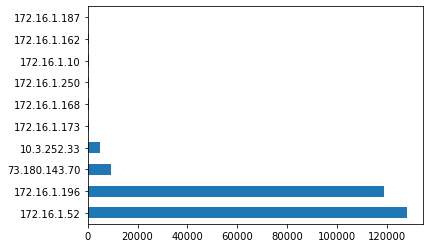

In [43]:
df[df['cluster_label']==4].sourceIP.value_counts().head(10).plot.barh()

<AxesSubplot:>

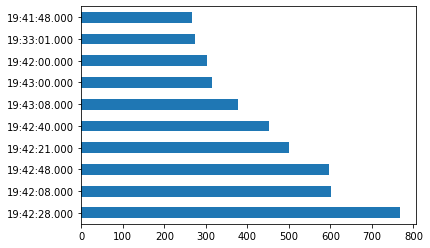

In [44]:
df[df['sourceIP'].str.contains('73.180.143.70')].time.value_counts().head(10).plot.barh()

In [45]:
df[df['sourceIP'].str.contains('73.180.143.70')].timeTook.describe()

count    26499.000000
mean        12.240726
std          2.393489
min          0.000000
25%         12.000000
50%         13.000000
75%         13.000000
max         21.000000
Name: timeTook, dtype: float64

In [46]:
df[df['sourceIP'].str.contains('73.180.143.70')].timeTook.value_counts()

13    13806
9      4407
12     3039
17     1873
8      1798
16     1105
11      222
7        99
10       78
21       20
14       17
15       15
2        12
6         2
5         2
4         2
1         1
0         1
Name: timeTook, dtype: int64

### Conclusion: although majorly its the internal ports (172.16.1.XXX) that creates the high traffic, there's no attacks detected that could possibly cursh the server.
### There are 2 suspicious factors in the data that's abnormal:
#### 1. The rejections from 10.3.252.33 address is too much.
#### 2. The ip address 73.180.143.70 has abnormal behaviors as a normal client as it sends hundreds of requests in different time stamps. Each request's process time is similar and results shiftings the in the cluster.

#### Continue the work

In [110]:
timeFreq = dict()
for index, line in df.iterrows():
    #filter out the signal that come from the server ip
    if line['sourceIP'] != '50.245.225.205':
        n = int(line['startTime'])
        t = n - 1612980720
        if t in timeFreq.keys():
            timeFreq[t] = timeFreq[t] + 1
        else:
            timeFreq[t] = 1

In [111]:
timeFreq.keys()

dict_keys([180, 179, 178, 177, 176, 175, 174, 172, 171, 170, 168, 167, 166, 163, 162, 161, 157, 156, 155, 153, 152, 151, 150, 149, 148, 147, 144, 143, 142, 140, 139, 138, 135, 134, 133, 132, 131, 129, 128, 126, 125, 122, 118, 116, 115, 114, 112, 111, 110, 109, 107, 106, 105, 104, 102, 101, 97, 96, 95, 94, 93, 92, 91, 89, 84, 83, 82, 81, 80, 79, 78, 77, 72, 69, 68, 67, 65, 63, 62, 60, 59, 58, 57, 56, 54, 53, 52, 50, 49, 48, 47, 46, 44, 43, 42, 41, 40, 38, 35, 34, 33, 31, 30, 29, 27, 26, 25, 24, 23, 22, 21, 20, 19, 16, 14, 13, 12, 11, 10, 9, 8, 6, 5, 4, 3, 2, 1, 0, 300, 298, 296, 292, 290, 289, 288, 284, 283, 282, 281, 280, 279, 278, 277, 275, 272, 271, 268, 267, 265, 264, 263, 261, 260, 259, 257, 256, 255, 254, 253, 252, 251, 248, 247, 246, 244, 241, 240, 238, 231, 230, 229, 228, 227, 226, 225, 224, 223, 222, 221, 220, 219, 217, 213, 212, 211, 210, 209, 208, 207, 206, 205, 204, 203, 201, 200, 195, 194, 193, 192, 191, 190, 188, 186, 185, 182, 181, 419, 418, 417, 416, 415, 414, 411, 410, 

In [112]:
sorted(timeFreq.keys())

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 16,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 29,
 30,
 31,
 33,
 34,
 35,
 38,
 40,
 41,
 42,
 43,
 44,
 46,
 47,
 48,
 49,
 50,
 52,
 53,
 54,
 56,
 57,
 58,
 59,
 60,
 62,
 63,
 65,
 67,
 68,
 69,
 72,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 89,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 101,
 102,
 104,
 105,
 106,
 107,
 109,
 110,
 111,
 112,
 114,
 115,
 116,
 118,
 122,
 125,
 126,
 128,
 129,
 131,
 132,
 133,
 134,
 135,
 138,
 139,
 140,
 142,
 143,
 144,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 155,
 156,
 157,
 161,
 162,
 163,
 166,
 167,
 168,
 170,
 171,
 172,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 185,
 186,
 188,
 190,
 191,
 192,
 193,
 194,
 195,
 200,
 201,
 203,
 204,
 205,
 206,
 207,
 208,
 209,
 210,
 211,
 212,
 213,
 217,
 219,
 220,
 221,
 222,
 223,
 224,
 225,
 226,
 227,
 228,
 229,
 230,
 231,
 238,
 240,
 241,
 244,
 246,
 247,
 248,
 251,
 252,
 253,
 254,
 255,
 256,
 257,
 

Estimated coefficients:
b_0 = 209.80433935327562            
b_1 = -0.017031978173520743


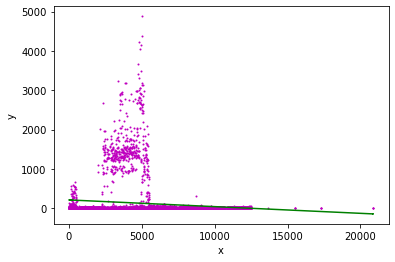

In [113]:
import numpy as np
import matplotlib.pyplot as plt
 
def estimate_coef(x, y):
    # number of observations/points
    n = np.size(x)
 
    # mean of x and y vector
    m_x = np.mean(x)
    m_y = np.mean(y)
 
    # calculating cross-deviation and deviation about x
    SS_xy = np.sum(y*x) - n*m_y*m_x
    SS_xx = np.sum(x*x) - n*m_x*m_x
 
    # calculating regression coefficients
    b_1 = SS_xy / SS_xx
    b_0 = m_y - b_1*m_x
 
    return (b_0, b_1)
 
def plot_regression_line(x, y, b):
    # plotting the actual points as scatter plot
    plt.scatter(x, y, color = "m",
               marker = "o", s = 1)
        # predicted response vector
    y_pred = b[0] + b[1]*x
 
    # plotting the regression line
    plt.plot(x, y_pred, color = "g")
 
    # putting labels
    plt.xlabel('x')
    plt.ylabel('y')
 
    # function to show plot
    plt.show()
 
def main():
    # observations / data
    x = np.array(list(timeFreq.keys()))
    y = np.array(list(timeFreq.values()))
 
    # estimating coefficients
    b = estimate_coef(x, y)
    print("Estimated coefficients:\nb_0 = {}  \
          \nb_1 = {}".format(b[0], b[1]))
 
    # plotting regression line
    plot_regression_line(x, y, b)
 
if __name__ == "__main__":
    main()

#### The linear regression gives the coeficients of 208.8 signals/second. The graph shows unbalanced relationship. Abnormal behaviors detected around the 5000 second time frame

In [139]:
sorted(timeFreq.items(), key=lambda x: (-x[1], x[0]))

[(5008, 4880),
 (4981, 4374),
 (4800, 4227),
 (4920, 4146),
 (4861, 4052),
 (4761, 3678),
 (4941, 3500),
 (4741, 3416),
 (4808, 3314),
 (3340, 3246),
 (5021, 3192),
 (3945, 3188),
 (3881, 3179),
 (5108, 3142),
 (5020, 3140),
 (4888, 3068),
 (4876, 3054),
 (4824, 3014),
 (4676, 2982),
 (4656, 2976),
 (5120, 2974),
 (4629, 2967),
 (3628, 2954),
 (3549, 2936),
 (4848, 2916),
 (4936, 2914),
 (4269, 2911),
 (3608, 2910),
 (4948, 2906),
 (3488, 2894),
 (3508, 2884),
 (5061, 2860),
 (4836, 2822),
 (4812, 2800),
 (4894, 2792),
 (4500, 2776),
 (3868, 2774),
 (4108, 2757),
 (4728, 2756),
 (3509, 2752),
 (4916, 2738),
 (3605, 2714),
 (4369, 2714),
 (4833, 2712),
 (4908, 2704),
 (4669, 2684),
 (4657, 2676),
 (4868, 2670),
 (4880, 2664),
 (2336, 2663),
 (3617, 2658),
 (4929, 2652),
 (3485, 2648),
 (5068, 2642),
 (5037, 2628),
 (4997, 2620),
 (5036, 2574),
 (4856, 2548),
 (4904, 2544),
 (4845, 2516),
 (3496, 2504),
 (4996, 2488),
 (5049, 2468),
 (3933, 2416),
 (5048, 2414),
 (4984, 2410),
 (3954, 23

### Analysis on the highest signals sent

In [144]:
potentialAttackIPs = []
for x,y in timeFreq.items():
    if y > 1000:
        potentialAttackIPs.extend(df[df['startTime'] == (x + 1612980720)].sourceIP.tolist())

In [145]:
len(potentialAttackIPs)

656134

In [146]:
tempDF = pd.DataFrame({
    'potentialAttackIPs':potentialAttackIPs
})

In [147]:
tempDF.value_counts()

potentialAttackIPs
172.16.1.52           317942
172.16.1.196          294729
73.180.143.70          22055
10.3.252.33            14001
50.230.35.38            2248
                       ...  
201.48.128.137             1
201.90.9.90                1
202.169.53.11              1
204.2.134.162              1
97.89.179.98               1
Length: 285, dtype: int64

## Found 2 attacks from these 2 ip address: 172.16.1.52 and 172.16.1.196. Both performed abnormal behaviors to the server, making over thousands of requests within seconds to the server. 